In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from datetime import date
from datetime import time
from datetime import timedelta
import numpy as np
import bcolz
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn as sns
import statsmodels.api as sm
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

/home/nighturs/Projects/swimmingpool-ipcam-analysis/env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.


# Calculate ResNet50 conv vecs

In [ ]:
resnet_model = ResNet50(include_top=False, input_shape=(3, 224, 224))

In [4]:
def save_array(fname, arr): 
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname): 
    return bcolz.open(fname)[:]

def save_resnet_vecs(vec_fname, img_name_fname, folder):
    gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    batches = gen.flow_from_directory(folder, 
                                      target_size=(224, 224), 
                                      batch_size=64, 
                                      class_mode=None,
                                      shuffle=False)
    vecs = resnet_model.predict_generator(batches, steps=(batches.samples + batches.batch_size) 
                                          // batches.batch_size, verbose=1)
    save_array(vec_fname, vecs)
    save_array(img_name_fname, batches.filenames)
    
def load_resnet_vecs(vec_fname, img_name_fname):
    return load_array(img_name_fname), load_array(vec_fname)

In [ ]:
save_resnet_vecs('vecs_all_20171127', 'img_name_all_20171127', '../data/all')

# Predict all images

In [2]:
def dtfstr(img_name):
    return datetime.strptime(img_name[:-4], '%Y%m%d%H%M%S')

In [5]:
fnames_all, vecs_all = load_resnet_vecs('vecs_all_20171127', 'img_name_all_20171127')

In [6]:
df = pd.read_csv('../data/916labels.csv')
df = pd.DataFrame({'img': [x[5:] for x in fnames_all], 'vec_id': range(fnames_all.size)}).merge(df, on='img', how='right')

x_train = vecs_all[df.vec_id].reshape(df.shape[0], 2048)
y_train = np.array(df.guessed)
x_train.shape, y_train.shape

((916, 2048), (916,))

In [7]:
regr = linear_model.Ridge(alpha = 100)
regr.fit(x_train, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [8]:
preds = regr.predict(vecs_all.reshape(vecs_all.shape[0], 2048))

In [9]:
df = pd.DataFrame({'datetime': [dtfstr(x[5:]).replace(second=0) for x in fnames_all], 'swimmers': preds}, 
                  index=[dtfstr(x[5:]).replace(second=0) for x in fnames_all])
df = df.sort_index(axis=0)
df.head(n=10)

,datetime,swimmers
2017-09-06 11:47:00,2017-09-06 11:47:00,-0.256686
2017-09-06 11:48:00,2017-09-06 11:48:00,-0.063244
2017-09-06 11:49:00,2017-09-06 11:49:00,-0.080743
2017-09-06 11:50:00,2017-09-06 11:50:00,0.193151
2017-09-06 11:52:00,2017-09-06 11:52:00,0.106457
2017-09-06 11:53:00,2017-09-06 11:53:00,-0.577290
2017-09-06 11:55:00,2017-09-06 11:55:00,-0.339471
2017-09-06 11:56:00,2017-09-06 11:56:00,0.720138
2017-09-06 11:57:00,2017-09-06 11:57:00,1.236817
2017-09-06 12:00:00,2017-09-06 12:00:00,1.448742


#  Weekday analysis

In [10]:
date_count = df['datetime'].groupby(df.datetime.dt.date).count()

In [11]:
good_days = date_count[date_count > 400].index.values
good_days

array([datetime.date(2017, 9, 6), datetime.date(2017, 9, 7),
       datetime.date(2017, 9, 8), datetime.date(2017, 9, 9),
       datetime.date(2017, 9, 11), datetime.date(2017, 9, 12),
       datetime.date(2017, 9, 13), datetime.date(2017, 9, 14),
       datetime.date(2017, 9, 16), datetime.date(2017, 9, 18),
       datetime.date(2017, 9, 19), datetime.date(2017, 9, 20),
       datetime.date(2017, 9, 21), datetime.date(2017, 9, 22),
       datetime.date(2017, 9, 25), datetime.date(2017, 9, 26),
       datetime.date(2017, 9, 27), datetime.date(2017, 9, 28),
       datetime.date(2017, 9, 29), datetime.date(2017, 10, 2),
       datetime.date(2017, 10, 3), datetime.date(2017, 10, 4),
       datetime.date(2017, 10, 10), datetime.date(2017, 10, 11),
       datetime.date(2017, 10, 12), datetime.date(2017, 10, 13),
       datetime.date(2017, 10, 16), datetime.date(2017, 10, 17),
       datetime.date(2017, 10, 18), datetime.date(2017, 10, 19),
       datetime.date(2017, 10, 20), datetime.date(2

In [12]:
d = df.index.min().date()
stop = (df.index.max() + timedelta(1)).date()
d, stop
minutes = []
while d < stop:
    if d not in good_days or d == date(2017, 11, 6) or d == date(2017, 11, 7):
        d = d + timedelta(1)
        continue
    t = datetime.combine(d, time(8, 0))
    stop_t = datetime.combine(d, time(21, 0))
    while t < stop_t:
        minutes.append(t)
        t = t + timedelta(0, 60)
    d = d + timedelta(1)
minutes[:10]

[datetime.datetime(2017, 9, 6, 8, 0),
 datetime.datetime(2017, 9, 6, 8, 1),
 datetime.datetime(2017, 9, 6, 8, 2),
 datetime.datetime(2017, 9, 6, 8, 3),
 datetime.datetime(2017, 9, 6, 8, 4),
 datetime.datetime(2017, 9, 6, 8, 5),
 datetime.datetime(2017, 9, 6, 8, 6),
 datetime.datetime(2017, 9, 6, 8, 7),
 datetime.datetime(2017, 9, 6, 8, 8),
 datetime.datetime(2017, 9, 6, 8, 9)]

In [13]:
df = df.reindex(minutes, method='nearest')
df['datetime'] = df.index
df.head()

,datetime,swimmers
2017-09-06 08:00:00,2017-09-06 08:00:00,-0.256686
2017-09-06 08:01:00,2017-09-06 08:01:00,-0.256686
2017-09-06 08:02:00,2017-09-06 08:02:00,-0.256686
2017-09-06 08:03:00,2017-09-06 08:03:00,-0.256686
2017-09-06 08:04:00,2017-09-06 08:04:00,-0.256686


In [14]:
def get_ts(df, weekday, resample='10S'):
    wd = df[df.datetime.dt.dayofweek == weekday]
    wd.index = pd.date_range(datetime(2000, 1, 1), datetime(2000, 1, 1) + timedelta(0, wd.shape[0] - 1), freq='S')
    wd = wd.resample(resample).mean()
    return wd

def seasonal_decompose(ts, freq=13 * 6):
    return sm.tsa.seasonal_decompose(ts['swimmers'], model='additive', freq=freq)

def decomposition_plot(decomposition):
    fig = decomposition.plot()
    fig.set_size_inches(20,10)
    plt.show()
    
def day_swimmers_plot(decomposition, freq=13 * 6):
    hits = {}
    for i, x in enumerate(decomposition.resid):
        if pd.isnull(x):
            continue
        ind = i % freq
        if not ind in hits:
            hits[ind]=[x]
        else:
            hits[ind].append(x)

    points_in_hour = freq // 13
    min_span = 60 // points_in_hour
    plot_dt = pd.DataFrame({'min': ['{}:{}'.format(8 + x // points_in_hour, min_span * (x % points_in_hour)) for x in range(freq)], 
                  'seas': decomposition.seasonal[:freq].as_matrix(), 
                  'low': [decomposition.seasonal[x] + np.min(hits[x]) for x in range(freq)],
                  'high': [decomposition.seasonal[x] + np.max(hits[x]) for x in range(freq)]}, index=range(freq))
    fig, ax = plt.subplots(1,1) 
    fig.set_size_inches(20,10)
    ax.plot(plot_dt['seas'])
    ax.plot(plot_dt['low'])
    ax.plot(plot_dt['high'])
    ax.set_xticks(range(len(plot_dt['high'])))
    ax.set_xticklabels(plot_dt['min'], rotation='vertical', fontsize=10)
    plt.grid()
    plt.show()

## Mondays

In [15]:
ts = get_ts(df, 0, resample='5S')
decomposition = seasonal_decompose(ts, 13 * 6 * 2)

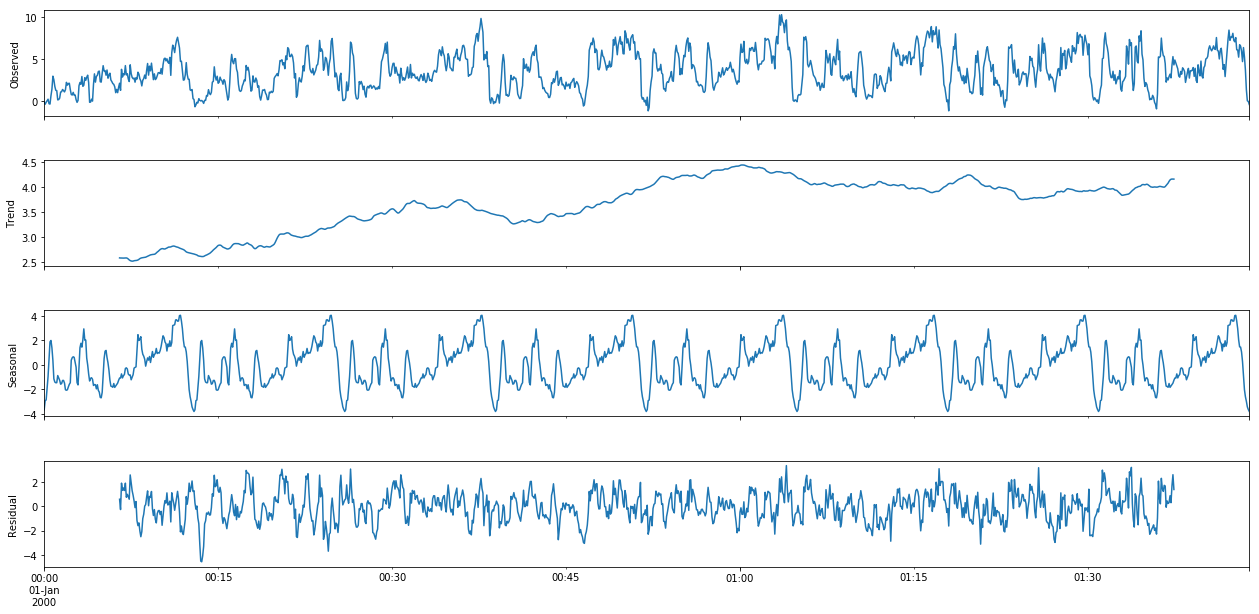

In [16]:
decomposition_plot(decomposition)

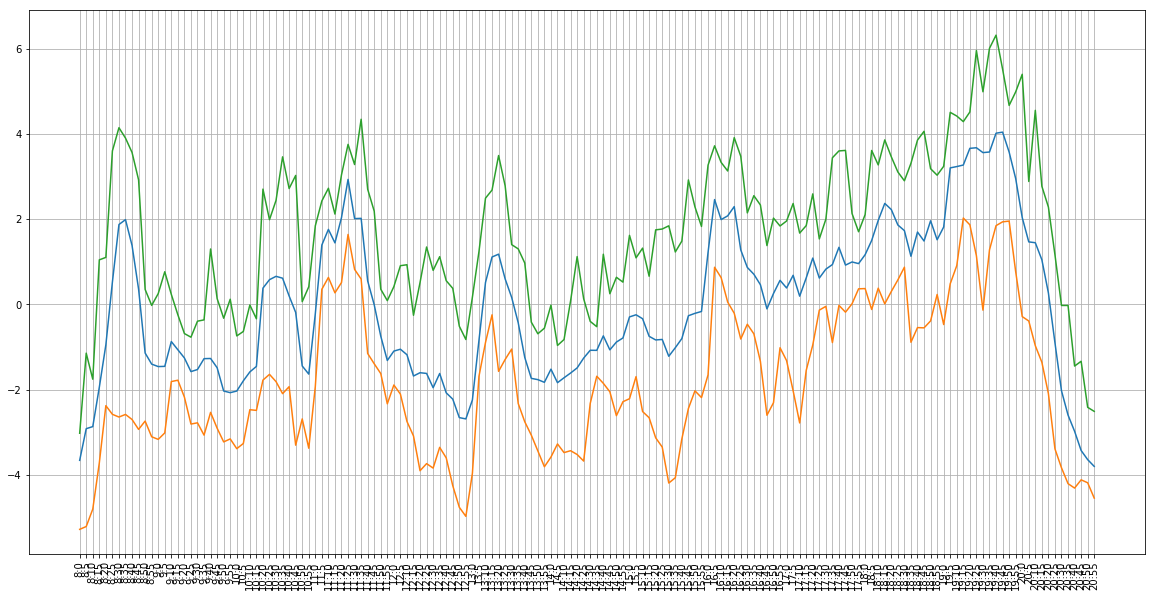

In [17]:
day_swimmers_plot(decomposition, 13 * 6 * 2)

## Tuesday

In [18]:
ts = get_ts(df, 1, resample='5S')
decomposition = seasonal_decompose(ts, 13 * 6 * 2)

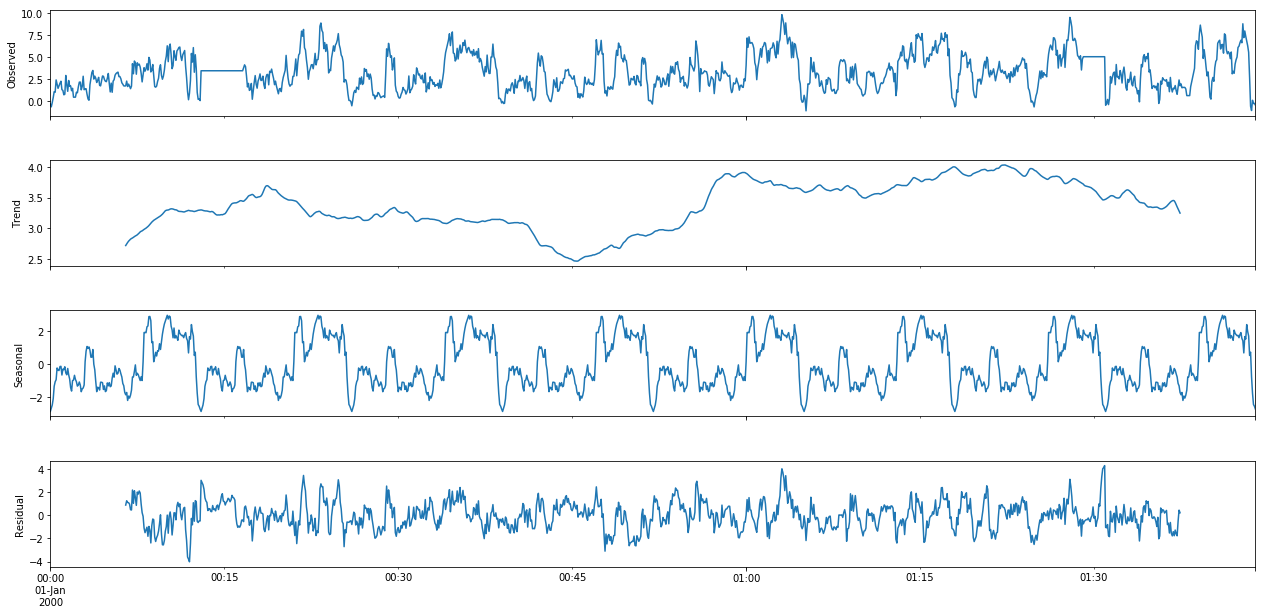

In [19]:
decomposition_plot(decomposition)

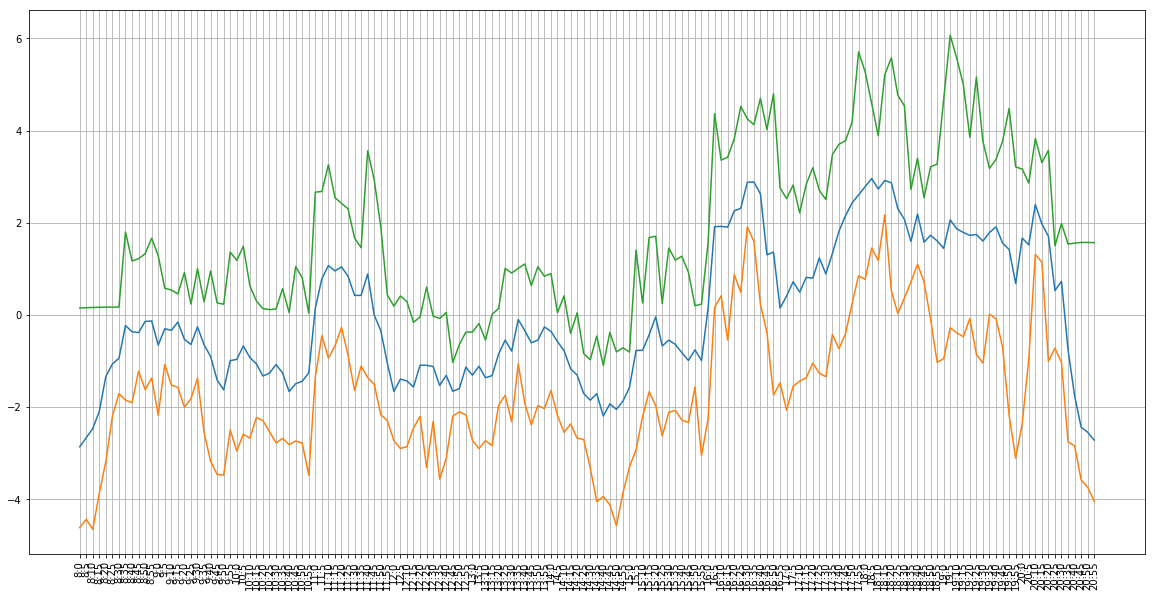

In [20]:
day_swimmers_plot(decomposition, 13 * 6 * 2)

## Wednesday

In [21]:
ts = get_ts(df, 2, resample='5S')
decomposition = seasonal_decompose(ts, 13 * 6 * 2)

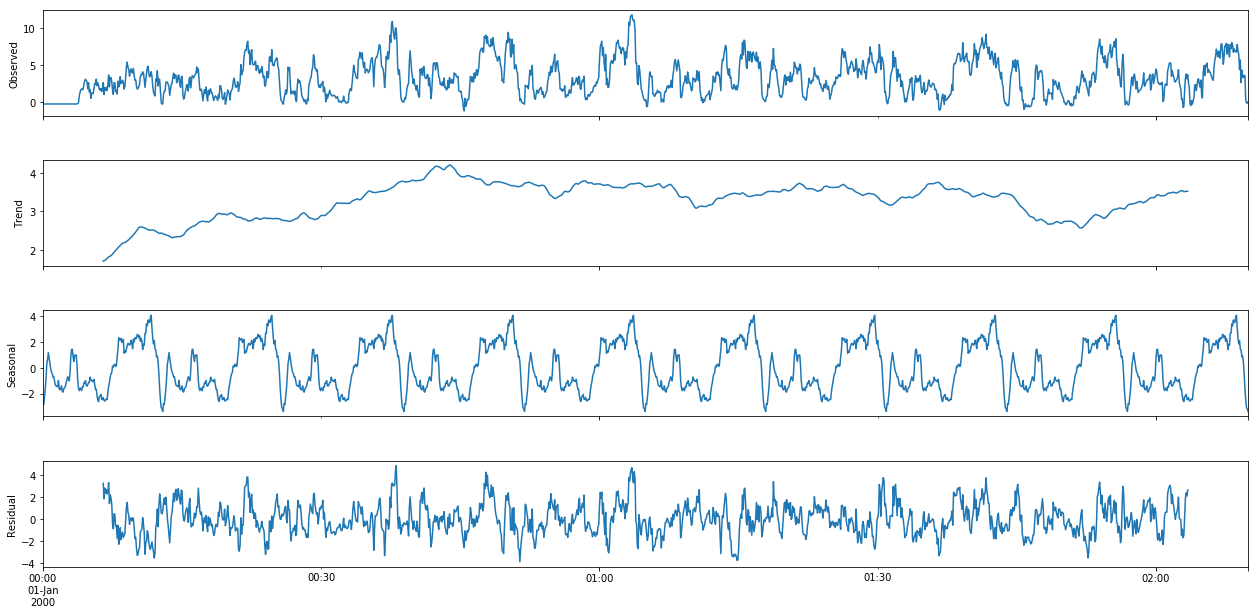

In [22]:
decomposition_plot(decomposition)

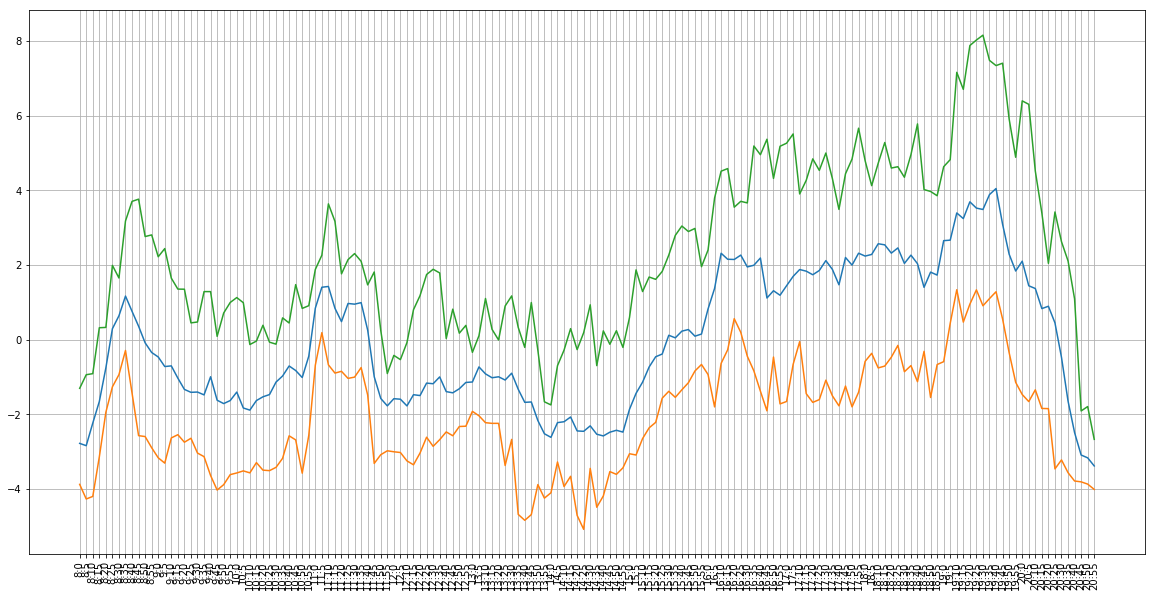

In [23]:
day_swimmers_plot(decomposition, 13 * 6 * 2)

## Thursday

In [24]:
ts = get_ts(df, 3, resample='5S')
decomposition = seasonal_decompose(ts, 13 * 6 * 2)

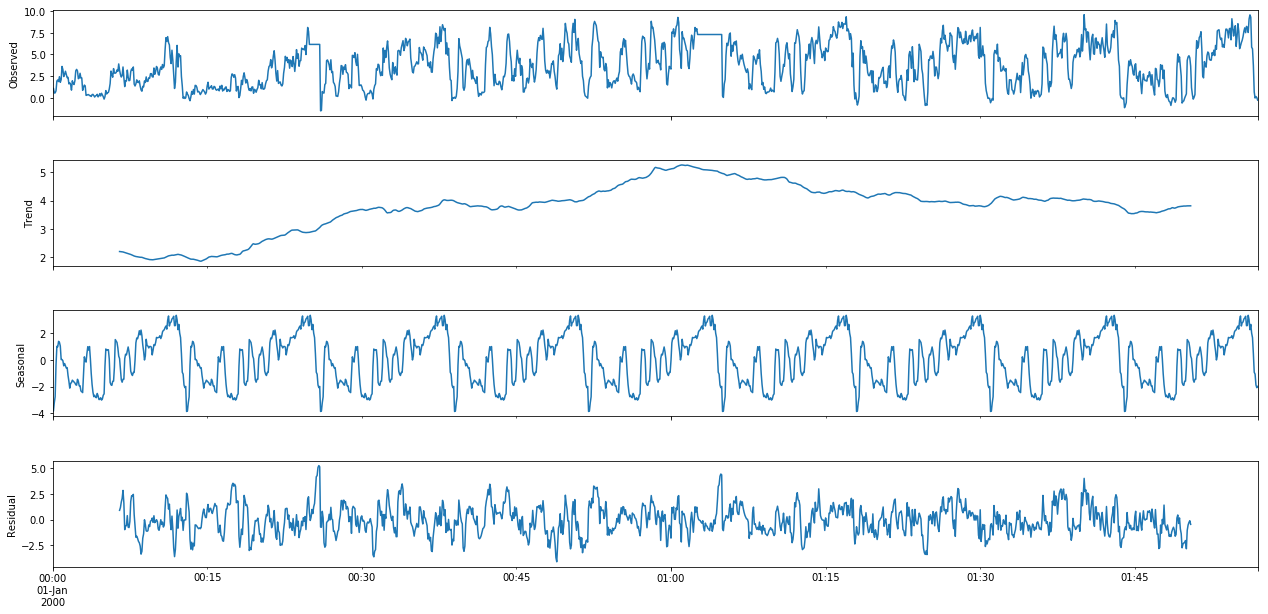

In [25]:
decomposition_plot(decomposition)

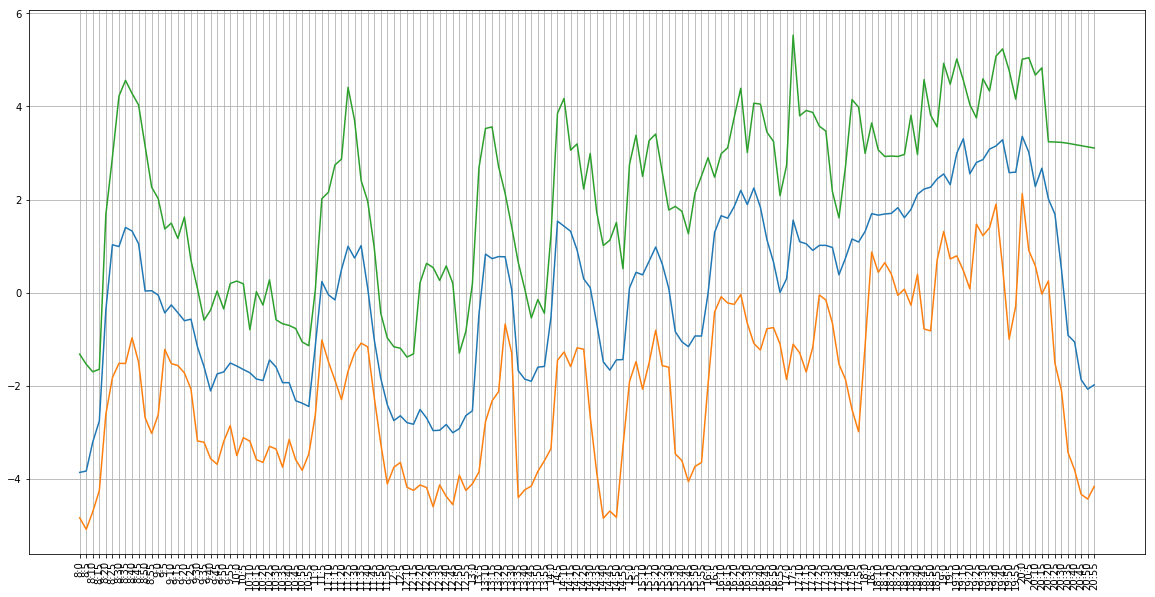

In [26]:
day_swimmers_plot(decomposition, 13 * 6 * 2)

## Friday

In [27]:
ts = get_ts(df, 4, resample='5S')
decomposition = seasonal_decompose(ts, 13 * 6 * 2)

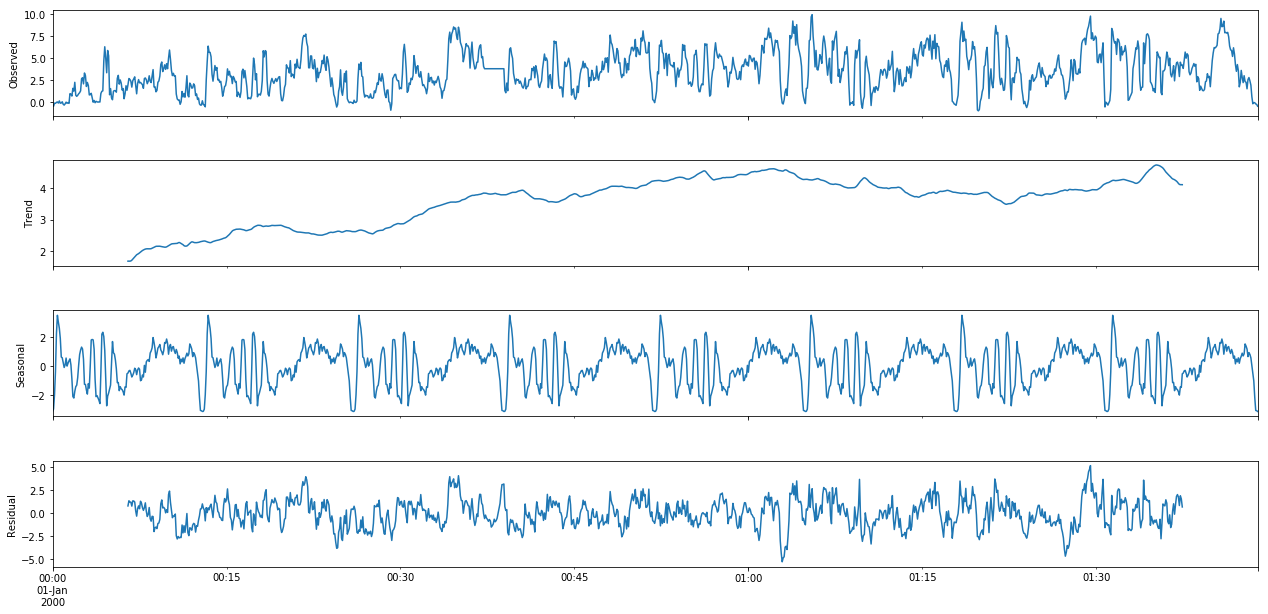

In [28]:
decomposition_plot(decomposition)

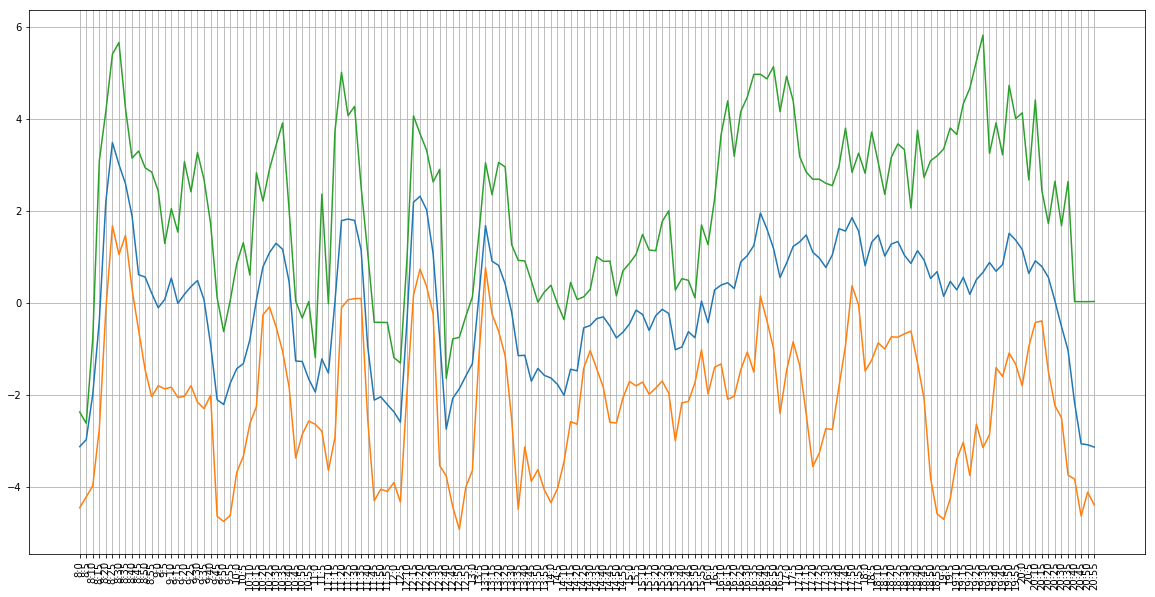

In [29]:
day_swimmers_plot(decomposition, 13 * 6 * 2)

## Saturday

In [30]:
ts = get_ts(df, 5, resample='5S')
decomposition = seasonal_decompose(ts, 13 * 6 * 2)

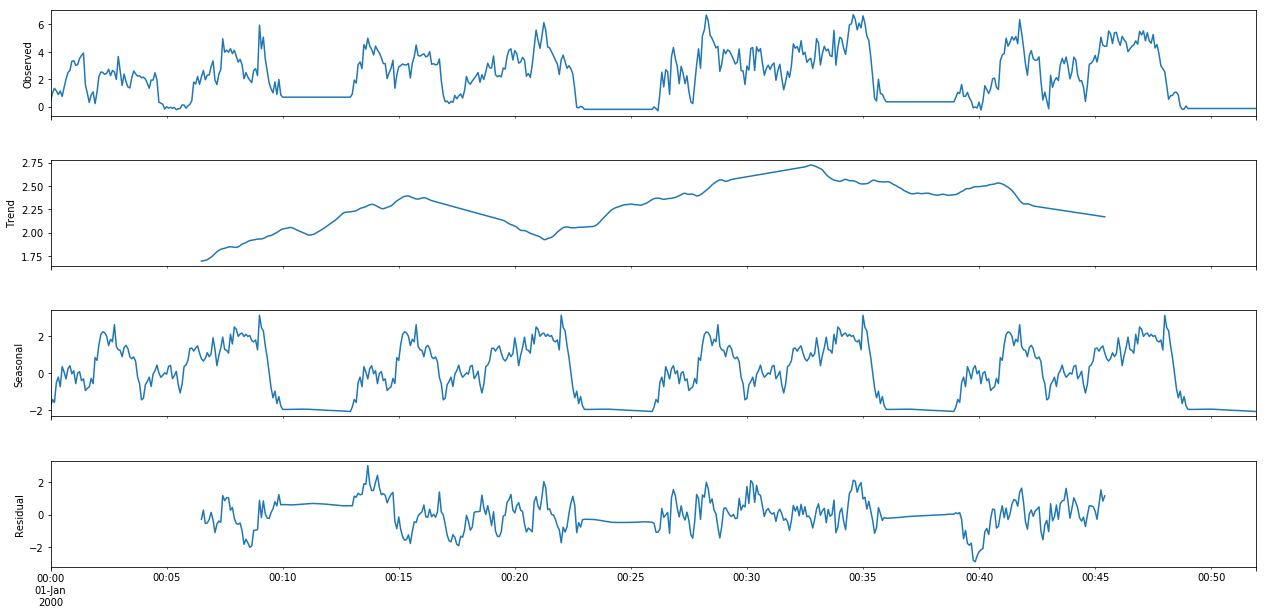

In [31]:
decomposition_plot(decomposition)

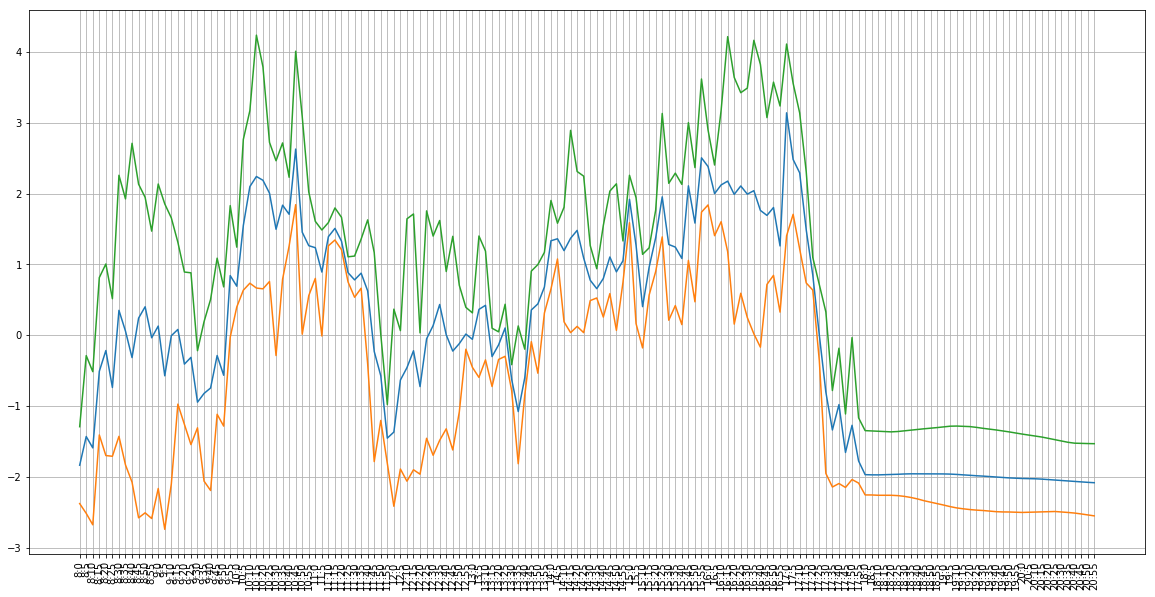

In [32]:
day_swimmers_plot(decomposition, 13 * 6 * 2)